#**Store Demand Forecasting**
##Masmur Toloni Harefa
##Dataset : https://www.kaggle.com/c/demand-forecasting-kernels-only

In [ ]:
!pip install pmdarima


#Import Library and Dataset

In [1]:

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('/content/drive/MyDrive/MLlearn/forecast1/train.csv')
test = pd.read_csv('/content/drive/MyDrive/MLlearn/forecast1/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/MLlearn/forecast1/sample_submission.csv')

train.head(), test.head()

(         date  store  item  sales
 0  2013-01-01      1     1     13
 1  2013-01-02      1     1     11
 2  2013-01-03      1     1     14
 3  2013-01-04      1     1     13
 4  2013-01-05      1     1     10,
    id        date  store  item
 0   0  2018-01-01      1     1
 1   1  2018-01-02      1     1
 2   2  2018-01-03      1     1
 3   3  2018-01-04      1     1
 4   4  2018-01-05      1     1)

#Exploratory Data Analisys

In [4]:
test.tail, sub.tail #check if sub_rows = test_rows

(<bound method NDFrame.tail of           id        date  store  item
 0          0  2018-01-01      1     1
 1          1  2018-01-02      1     1
 2          2  2018-01-03      1     1
 3          3  2018-01-04      1     1
 4          4  2018-01-05      1     1
 ...      ...         ...    ...   ...
 44995  44995  2018-03-27     10    50
 44996  44996  2018-03-28     10    50
 44997  44997  2018-03-29     10    50
 44998  44998  2018-03-30     10    50
 44999  44999  2018-03-31     10    50
 
 [45000 rows x 4 columns]>,
 <bound method NDFrame.tail of           id  sales
 0          0     52
 1          1     52
 2          2     52
 3          3     52
 4          4     52
 ...      ...    ...
 44995  44995     52
 44996  44996     52
 44997  44997     52
 44998  44998     52
 44999  44999     52
 
 [45000 rows x 2 columns]>)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [6]:
#check null
train.isnull().sum(), test.isnull().sum()

(date     0
 store    0
 item     0
 sales    0
 dtype: int64,
 id       0
 date     0
 store    0
 item     0
 dtype: int64)

In [7]:
#how many total item in each store
train.groupby('store').size()

,0
store,
1,91300
2,91300
3,91300
4,91300
5,91300
6,91300
7,91300
8,91300
9,91300


In [8]:
train['item'].unique() #how many unique item per store

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

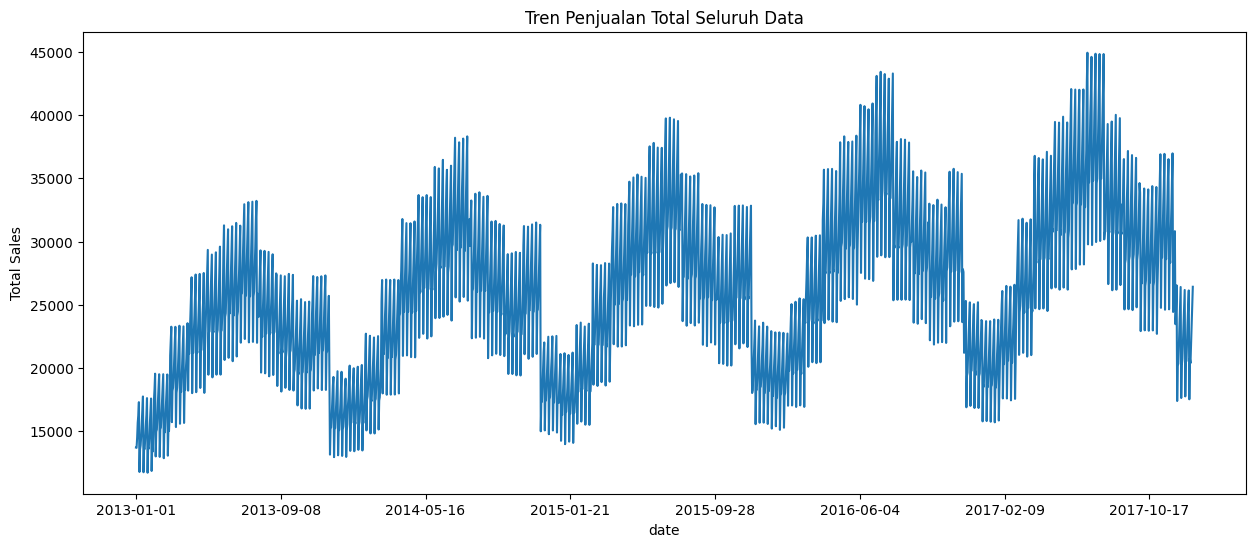

In [9]:
# plot tres total sales
daily_sales = train.groupby('date')['sales'].sum()

plt.figure(figsize=(15,6))
daily_sales.plot()
plt.title("Tren Penjualan Total Seluruh Data")
plt.ylabel("Total Sales")
plt.show()


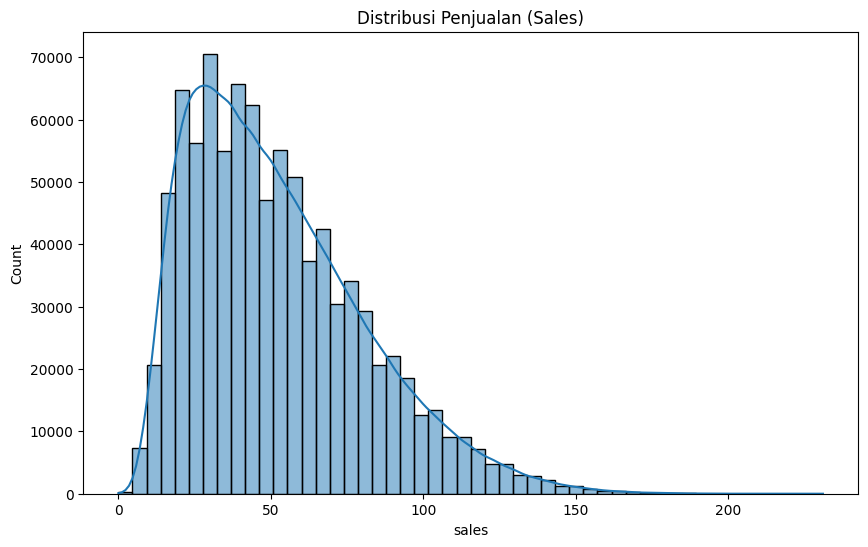

In [10]:
# check sales distribution
plt.figure(figsize=(10,6))
sns.histplot(train['sales'], bins=50, kde=True)
plt.title("Distribusi Penjualan (Sales)")
plt.show()

In [11]:
#add new time feature collumn

#in train
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day_of_week'] = train['date'].dt.dayofweek
train['is_weekend'] = train['day_of_week'].isin([5,6]).astype(int)

#in test
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day_of_week'] = test['date'].dt.dayofweek
train['is_weekend'] = train['day_of_week'].isin([5,6]).astype(int)



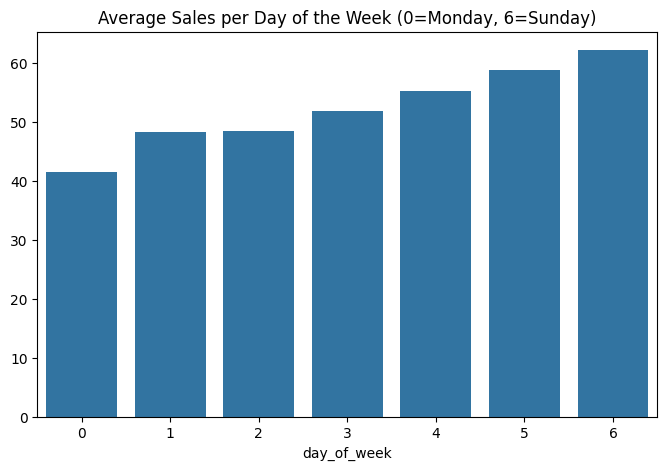

In [12]:
# Plot average sales every day per week
dow_sales = train.groupby('day_of_week')['sales'].mean()

plt.figure(figsize=(8,5))
sns.barplot(x=dow_sales.index, y=dow_sales.values)
plt.title("Average Sales per Day of the Week (0=Monday, 6=Sunday)")
plt.show()


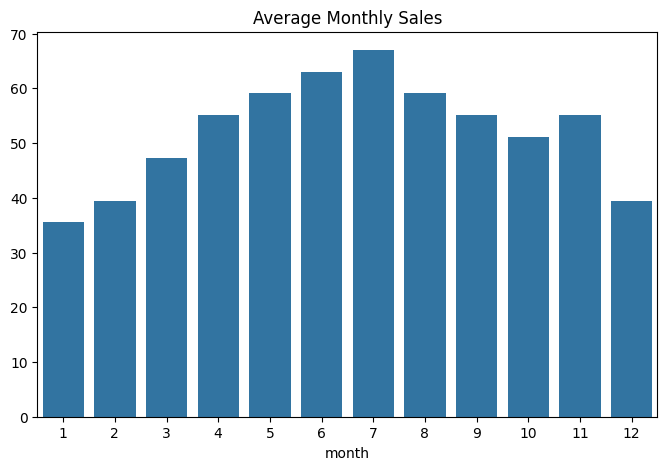

In [13]:
# Plot Average Monthly sales
monthly_sales = train.groupby('month')['sales'].mean()

plt.figure(figsize=(8,5))
sns.barplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title("Average Monthly Sales")
plt.show()

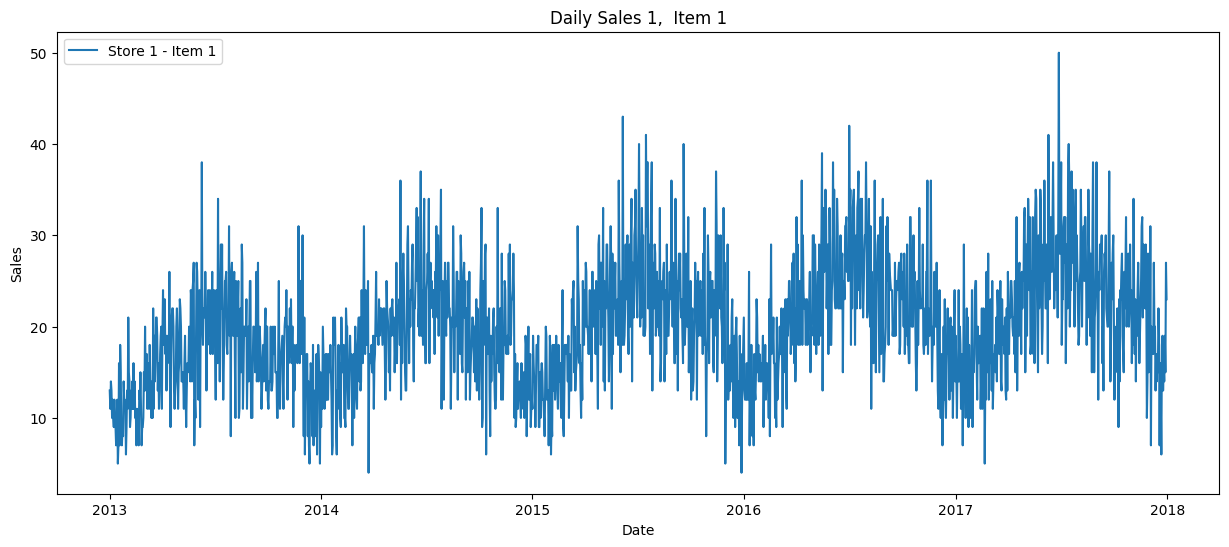

In [14]:
# Plot combination store-item
store1 = 1
item1 = 1

subset = train[(train['store'] == store1) & (train['item'] == item1)]
subset = subset.sort_values('date')

plt.figure(figsize=(15,6))
plt.plot(subset['date'], subset['sales'], label=f"Store {store1} - Item {item1}")
plt.title(f"Daily Sales {store1},  Item {item1}")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.legend()
plt.show()

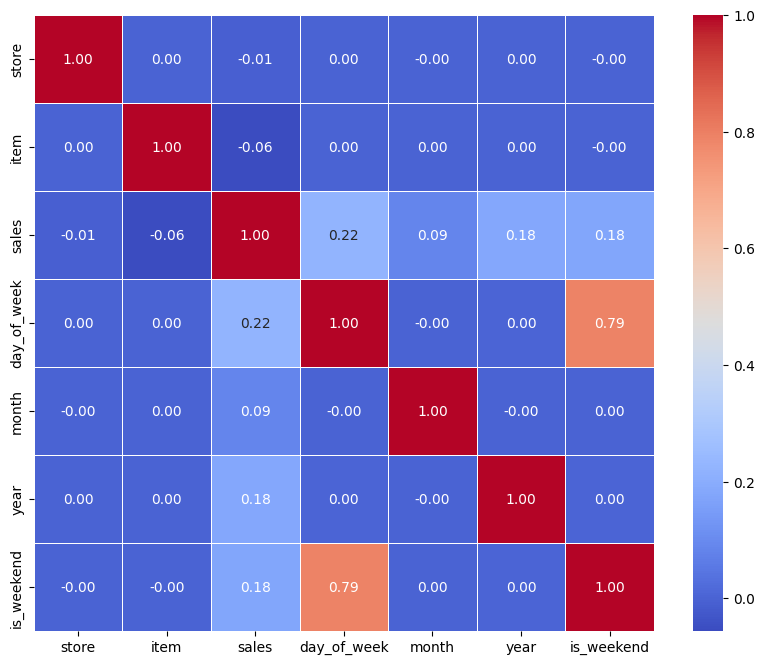

In [15]:
# corelation heatmap
num_cols = ['store', 'item', 'sales', 'day_of_week', 'month', 'year', 'is_weekend']
corr = train[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

#SARIMA Modelling

##Grid Search

In [16]:
import warnings
warnings.filterwarnings("ignore")

data = train[(train['store'] == store1) & (train['item'] == item1)].copy()
data = data.sort_values('date')
data.set_index('date', inplace=True)

# Grid Search Parameter
p = d = q = range(0, 2)    # 0/1
P = D = Q = range(0, 2)    # 0/1
s = 7                      # 7 day/week

import itertools
param_combinations = list(itertools.product(p, d, q, P, D, Q))

print(f"Total Combination tested: {len(param_combinations)}")

# Simpan hasil
results = []

# Loop semua kombinasi
for combination in param_combinations:
    order = (combination[0], combination[1], combination[2])
    seasonal_order = (combination[3], combination[4], combination[5], s)

    try:
        model1 = SARIMAX(data['sales'],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit1 = model1.fit(disp=False)

        results.append({
            'order': order,
            'seasonal_order': seasonal_order,
            'AIC': model_fit1.aic
        })

        print(f"Tested {order} x {seasonal_order} - AIC: {model_fit1.aic:.2f}")

    except:
        continue

# Hasil ke DataFrame
result1_df = pd.DataFrame(results)
best_model = result1_df.sort_values('AIC').iloc[0]

print("\n✅ Best Parameter Combination:")
print(f"Order: {best_model['order']}")
print(f"Seasonal Order: {best_model['seasonal_order']}")
print(f"AIC: {best_model['AIC']:.2f}")

Total Combination tested: 64
Tested (0, 0, 0) x (0, 0, 0, 7) - AIC: 16307.77
Tested (0, 0, 0) x (0, 0, 1, 7) - AIC: 14662.25
Tested (0, 0, 0) x (0, 1, 0, 7) - AIC: 11821.26
Tested (0, 0, 0) x (0, 1, 1, 7) - AIC: 11041.10
Tested (0, 0, 0) x (1, 0, 0, 7) - AIC: 11790.53
Tested (0, 0, 0) x (1, 0, 1, 7) - AIC: 11082.35
Tested (0, 0, 0) x (1, 1, 0, 7) - AIC: 11310.78
Tested (0, 0, 0) x (1, 1, 1, 7) - AIC: 11043.09
Tested (0, 0, 1) x (0, 0, 0, 7) - AIC: 14727.24
Tested (0, 0, 1) x (0, 0, 1, 7) - AIC: 13770.69
Tested (0, 0, 1) x (0, 1, 0, 7) - AIC: 11811.57
Tested (0, 0, 1) x (0, 1, 1, 7) - AIC: 11003.39
Tested (0, 0, 1) x (1, 0, 0, 7) - AIC: 11781.08
Tested (0, 0, 1) x (1, 0, 1, 7) - AIC: 11045.08
Tested (0, 0, 1) x (1, 1, 0, 7) - AIC: 11303.52
Tested (0, 0, 1) x (1, 1, 1, 7) - AIC: 11005.38
Tested (0, 1, 0) x (0, 0, 0, 7) - AIC: 12321.20
Tested (0, 1, 0) x (0, 0, 1, 7) - AIC: 12185.62
Tested (0, 1, 0) x (0, 1, 0, 7) - AIC: 12966.18
Tested (0, 1, 0) x (0, 1, 1, 7) - AIC: 11793.72
Tested (0, 

##Prediction


Using Best Parameter: (0, 1, 1) x (0, 1, 1, 7)

Train range: 2013-01-01 00:00:00 to 2017-10-02 00:00:00
Test range: 2017-10-02 00:00:00 to 2017-12-31 00:00:00


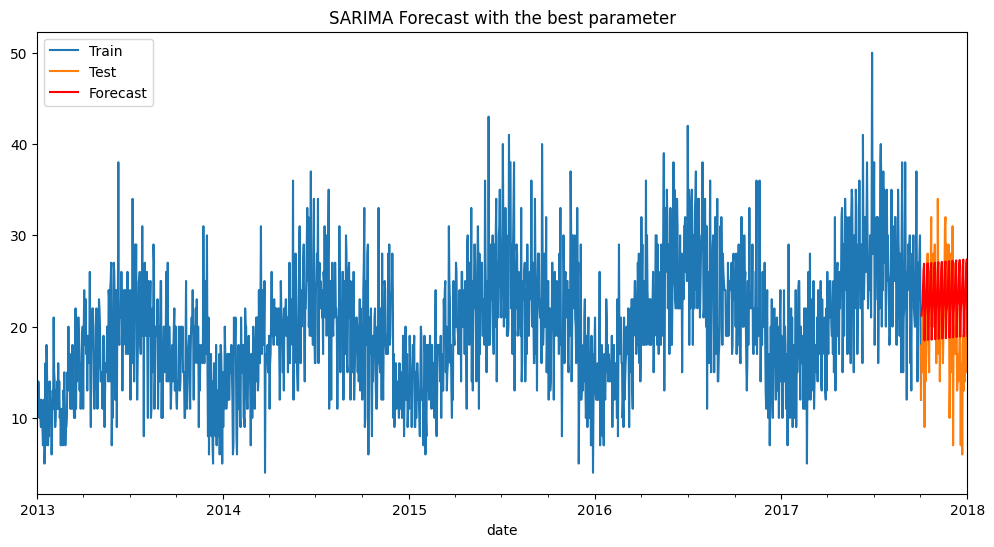

✅ RMSLE (with best param): 0.3774


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
import numpy as np

# best param
best_order = best_model['order']
best_seasonal_order = best_model['seasonal_order']

print(f"\nUsing Best Parameter: {best_order} x {best_seasonal_order}")

# split train and test to last 3 month(90 days)
split_date = data.index.max() - pd.DateOffset(days=90)
train_data = data[:split_date]
test_data = data[split_date:]

print(f"\nTrain range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test range: {test_data.index.min()} to {test_data.index.max()}")

# Build SARIMA with the best param
model = SARIMAX(train_data['sales'],
                order=best_order,
                seasonal_order=best_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Prediction for  test period
predictions = results.get_forecast(steps=len(test_data))
pred_mean = predictions.predicted_mean

# Plot prediction result
plt.figure(figsize=(12,6))
train_data['sales'].plot(label='Train')
test_data['sales'].plot(label='Test')
pred_mean.plot(label='Forecast', color='red')
plt.title('SARIMA Forecast with the best parameter')
plt.legend()
plt.show()

#  RMSLE Evaluation
y_true = test_data['sales'].values
y_pred = pred_mean.values
y_pred = np.maximum(y_pred, 0)  # not negative

rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"✅ RMSLE (with best param): {rmsle:.4f}")


##Final Prediction (On Test Data)

##Key Findings :
Parameter = (1, 0, 1) x (0, 1, 1, 7) is the one  used for predicting test data.

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")


# Combinations
combinations = test[['store', 'item']].drop_duplicates()

# Fixed Parameter
fixed_order = (1, 0, 1)
fixed_seasonal_order = (0, 1, 1, 7)

# List for saving predictions
predictions = []

# Loop every combinations of store-item
for idx, row in combinations.iterrows():

    store_id = row['store']
    item_id = row['item']

    print(f"Proses Store {store_id} - Item {item_id}")

    # Filter historical data
    history = train[(train['store'] == store_id) & (train['item'] == item_id)].copy()
    history = history.sort_values('date')
    history.set_index('date', inplace=True)

    # Filter test data
    test_subset = test[(test['store'] == store_id) & (test['item'] == item_id)].copy()
    test_subset = test_subset.sort_values('date')
    forecast_steps = len(test_subset)

    # Build model and prediction
    model = SARIMAX(history['sales'],
                    order=fixed_order,
                    seasonal_order=fixed_seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    results = model.fit(disp=False)

    pred = results.get_forecast(steps=forecast_steps)
    pred_mean = np.maximum(pred.predicted_mean.values, 0)

    # Join resutlt to test subset
    test_subset['sales'] = pred_mean
    predictions.append(test_subset)

# Merge all prediction
final_predictions = pd.concat(predictions)




Proses Store 1 - Item 1
Proses Store 2 - Item 1
Proses Store 3 - Item 1
Proses Store 4 - Item 1
Proses Store 5 - Item 1
Proses Store 6 - Item 1
Proses Store 7 - Item 1
Proses Store 8 - Item 1
Proses Store 9 - Item 1
Proses Store 10 - Item 1
Proses Store 1 - Item 2
Proses Store 2 - Item 2
Proses Store 3 - Item 2
Proses Store 4 - Item 2
Proses Store 5 - Item 2
Proses Store 6 - Item 2
Proses Store 7 - Item 2
Proses Store 8 - Item 2
Proses Store 9 - Item 2
Proses Store 10 - Item 2
Proses Store 1 - Item 3
Proses Store 2 - Item 3
Proses Store 3 - Item 3
Proses Store 4 - Item 3
Proses Store 5 - Item 3
Proses Store 6 - Item 3
Proses Store 7 - Item 3
Proses Store 8 - Item 3
Proses Store 9 - Item 3
Proses Store 10 - Item 3
Proses Store 1 - Item 4
Proses Store 2 - Item 4
Proses Store 3 - Item 4
Proses Store 4 - Item 4
Proses Store 5 - Item 4
Proses Store 6 - Item 4
Proses Store 7 - Item 4
Proses Store 8 - Item 4
Proses Store 9 - Item 4
Proses Store 10 - Item 4
Proses Store 1 - Item 5
Proses Store

KeyError: 'date'

#RESULT


In [18]:
final_predictions

,id,date,store,item,year,month,day_of_week,sales
0,0,2018-01-01,1,1,2018,1,0,12.776854
1,1,2018-01-02,1,1,2018,1,1,15.516095
2,2,2018-01-03,1,1,2018,1,2,16.164370
3,3,2018-01-04,1,1,2018,1,3,16.999170
4,4,2018-01-05,1,1,2018,1,4,18.430017
...,...,...,...,...,...,...,...,...
44995,44995,2018-03-27,10,50,2018,3,1,61.363802
44996,44996,2018-03-28,10,50,2018,3,2,62.798524
44997,44997,2018-03-29,10,50,2018,3,3,68.535785
44998,44998,2018-03-30,10,50,2018,3,4,73.322123


In [19]:
#For Kaggle submission

df_final = final_predictions[['id', 'sales']]
df_final.columns = ['id', 'sales']

from google.colab import files
df_final.to_csv('submission_arima.csv', index=False)
files.download('submission_arima.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>